# Costas Signal Processing
## By Terry Bondy, VA3TYB

In [1]:
printf(strftime ("Last updated: %A %e %B %Y", localtime (time ())))

Last updated: Tuesday  4 February 2020

1. Want to be able to process signals across a BW just a bit bigger than 100 kHz.
1. Want to be able to send 8 X 8 Costas signal using a radio with a BW 200 Hz - 2600 Hz.

In [2]:
frLow = 200
frHigh = 2600
bwRadio = frHigh - frLow
costasN = 8
deltaFcostas = bwRadio/costasN

frLow =  200
frHigh =  2600
bwRadio =  2400
costasN =  8
deltaFcostas =  300


To meet the Nyquist criteria, sampling rate > 2 * BWchannel. BWchannel is:

In [3]:
BWchannel = 100000

BWchannel =  100000


...and twice that is:

In [4]:
BWchannel * 2

ans =  200000


For the Costas signal, one subpulse period is 1/deltaFcostas

In [5]:
1/deltaFcostas

ans =  0.0033333


For processing, we want the number of samples to be processed in a bit period to be a power of two greater than

In [6]:
BWchannel * 2/deltaFcostas

ans =  666.67


or

In [7]:
pulseSamples = pow2(ceil(log2(BWchannel * 2/deltaFcostas)))

pulseSamples =  1024


In [8]:
sampleRate = pulseSamples * deltaFcostas

sampleRate =  307200


...which meets the Nyquist criteria nicely with lots of headroom.

To ensure continous phase between subpulses, the lowest freq. subpulse should be the same as deltaFcostas. So, the Costas signal baseband frequencies are:

In [9]:
costasFreq = deltaFcostas:deltaFcostas:deltaFcostas * costasN

costasFreq =

    300    600    900   1200   1500   1800   2100   2400



Need a frequency ordering. From _Modified Costas Signal, Levanon & Mozeson_ here is one:

In [10]:
costasFreqIdx = [ 1 8 3 6 2 7 5 4 ]

costasFreqIdx =

   1   8   3   6   2   7   5   4



Lets simulate trying to determine the offset frequency and offset time that a Costas signal is received. We'll use a reference signal of 0 Hz offset and 0 s time, just so wwe can find out what the processing offsets are.

First build up the reference signal

In [11]:
RefSigCoreCV = [ 0 ];
TimeCV = [0:1/sampleRate:1/deltaFcostas](:);
for idx = 1:1:costasN
  SubPulseCV = i * exp(i*2*pi*costasFreq(costasFreqIdx(idx))*TimeCV);
  # Add all but the first sample
  RefSigCoreCV = vertcat(RefSigCoreCV, SubPulseCV(2:end));
endfor

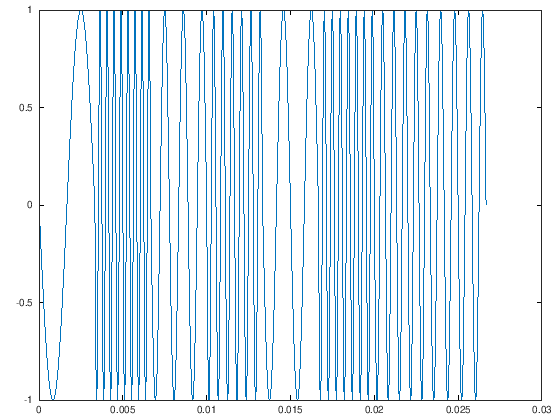

In [12]:
plot([0:1/sampleRate:costasN/deltaFcostas](:), RefSigCoreCV)

Lets add a subpulse of silence on each end

In [13]:
size(RefSigCoreCV)
costasN * pulseSamples
RefSigCV = vertcat(zeros(pulseSamples,1), RefSigCoreCV, zeros(pulseSamples,1));
size(RefSigCV)
(costasN + 2) * pulseSamples

ans =

   8193      1

ans =  8192
ans =

   10241       1

ans =  10240


In [14]:
# Need raised cosine for sampling subpulse
RaisedCosineCV = (1 - cos(2*pi*TimeCV*deltaFcostas))/2;
size(RaisedCosineCV)
# Each column represents freq response at a given moment in time
RespTimeFreq = [];
fracSubPulse = 1; # Must be a power of 2
indexIncr = pulseSamples/fracSubPulse;
i = 1;
for idx = 1:indexIncr:rows(RefSigCV)-(rows(RaisedCosineCV)-1)
  SigLoopCV = [RefSigCV(idx:idx+rows(RaisedCosineCV)-1) .* RaisedCosineCV](1:end-1);
  FftLoopCV = fftshift(fft(SigLoopCV, rows(SigLoopCV)*10));
  FreqLoopCV = linspace(-sampleRate/2, sampleRate/2, rows(FftLoopCV));
  # figure(i);
  # newplot()
  # plot(FreqLoopCV, abs(FftLoopCV))
  # title(sprintf("Figure %d", i++))
  # grid on
  # grid minor
  # axis([0 2600], "tic")
  # drawnow()
  RespTimeFreq = [RespTimeFreq FftLoopCV];
endfor
size(RespTimeFreq)

ans =

   1025      1

ans =

   10240      10



In [15]:
Z = conv2(RespTimeFreq, conj(rot90(RespTimeFreq,2)), 'valid');
size(Z)
absZ = abs(Z);
size(absZ)
maxAbsZ = max(absZ(:))

ans =

   1   1

ans =

   1   1

maxAbsZ =    3.1457e+07


## Does Phase of Correlation Correspond with Time Delay?

In [16]:
RefSigCV = vertcat(zeros(pulseSamples,1), RefSigCoreCV, zeros(pulseSamples,1));
RefSigFreqCV = fft(RefSigCV, rows(RefSigCV)*10);
size(RefSigFreqCV)
RefSigFreqKernelCV = conj(rot90(RefSigFreqCV,2));
MagCV = [];
for idx = -pulseSamples:1:pulseSamples
  RefSigLoopCV = vertcat(zeros(pulseSamples+idx,1), RefSigCoreCV, zeros(pulseSamples-idx,1));
  RefSigLoopFreqCV = fft(RefSigLoopCV, rows(RefSigLoopCV)*10);
  Z = conv2(RefSigLoopFreqCV, RefSigFreqKernelCV, 'valid');
  # size(Z)
  MagCV = [MagCV; Z];
endfor

ans =

   102410        1



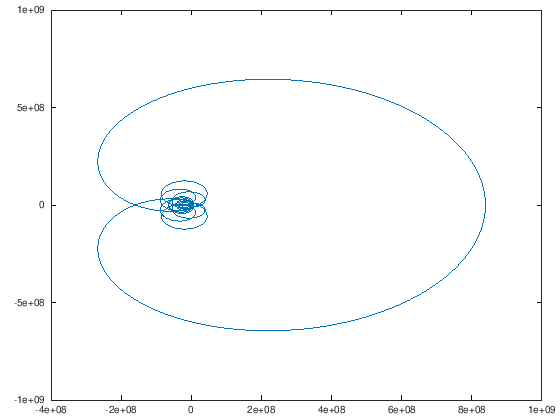

In [17]:
plot(MagCV)

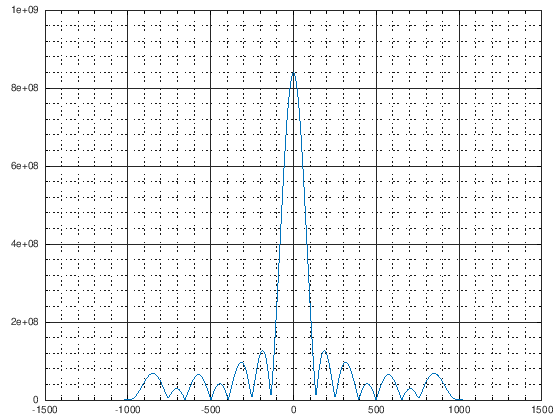

In [19]:
plot(-pulseSamples:1:pulseSamples, abs(MagCV))
grid on
grid minor
axis("tic")

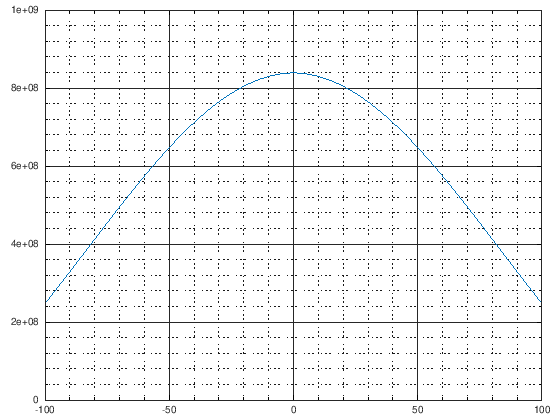

In [20]:
plot(-pulseSamples:1:pulseSamples, abs(MagCV))
grid on
grid minor
axis([-100 100], "tic")

In [24]:
AbsMagCV = abs(MagCV);
maxAbsMag = max(AbsMagCV)
maxAbsMag/1.414
find(AbsMagCV(:) >= ans);
[-pulseSamples:1:pulseSamples]([ans(1), ans(end)])

maxAbsMag =    8.3894e+08
ans =    5.9331e+08
ans =

  -57   57



In [25]:
RefSigCV = vertcat(RefSigCoreCV, RefSigCoreCV);
RefSigFreqCV = fft(RefSigCoreCV, rows(RefSigCoreCV)*10);
size(RefSigFreqCV)
RefSigFreqKernelCV = conj(rot90(RefSigFreqCV,2));
MagCV = [];
for idx = 0:1:rows(RefSigCoreCV)-1
  RefSigLoopFreqCV = fft(RefSigCV(idx+1:idx+rows(RefSigCoreCV)), rows(RefSigCoreCV)*10);
  Z = conv2(RefSigLoopFreqCV, RefSigFreqKernelCV, 'valid');
  # size(Z)
  MagCV = [MagCV; Z];
endfor

ans =

   81930       1



In [27]:
[linspace(-sampleRate/2, sampleRate/2, 8096)](8096/2-5:8096/2+5)

ans =

 Columns 1 through 8:

  -208.721  -170.772  -132.823   -94.873   -56.924   -18.975    18.975    56.924

 Columns 9 through 11:

    94.873   132.823   170.772



In [51]:
RefSigFreqCV = fftshift(fft(RefSigCoreCV .* conj(RefSigCoreCV), 10*rows(RefSigCoreCV)+1));
size(RefSigFreqCV)

ans =

   81931       1



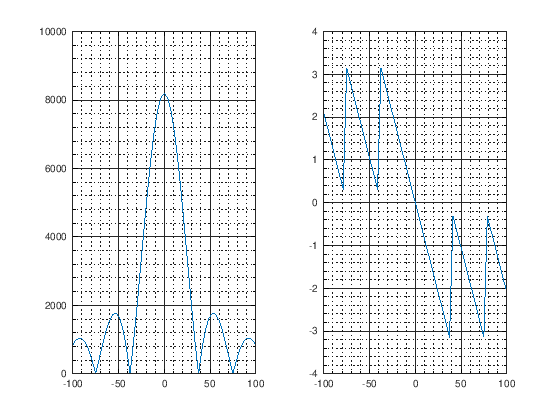

In [54]:
Freq = linspace(-sampleRate/2, sampleRate/2, rows(RefSigFreqCV));
subplot(1, 2, 1)
# plotyy(Freq, abs(RefSigFreqCV), Freq, arg(RefSigFreqCV))
plot(Freq, abs(RefSigFreqCV))
grid on
grid minor
axis([-100 100], "tic")
subplot(1, 2, 2)
plot(Freq, arg(RefSigFreqCV))
grid on
grid minor
axis([-100 100], "tic")

In [30]:
1024 * 8


ans =  8192


ans =

   30    1



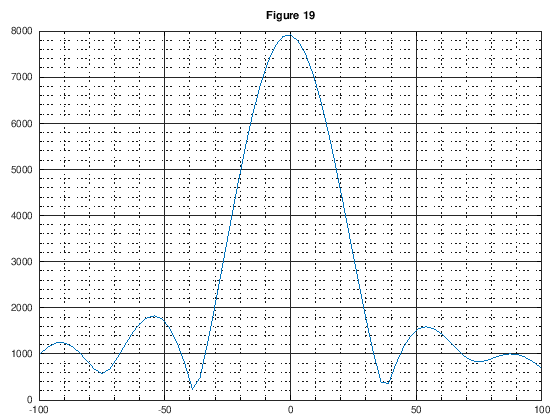

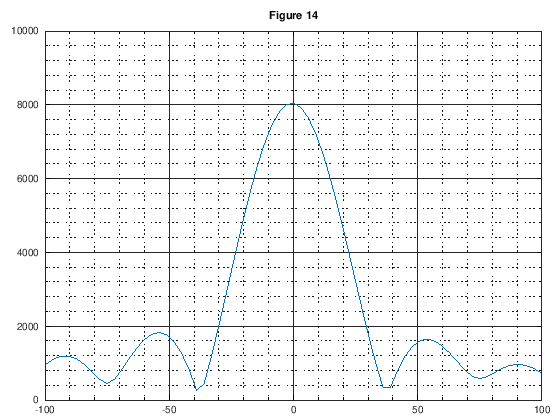

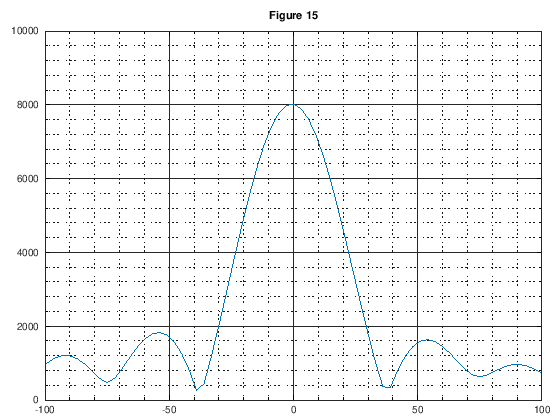

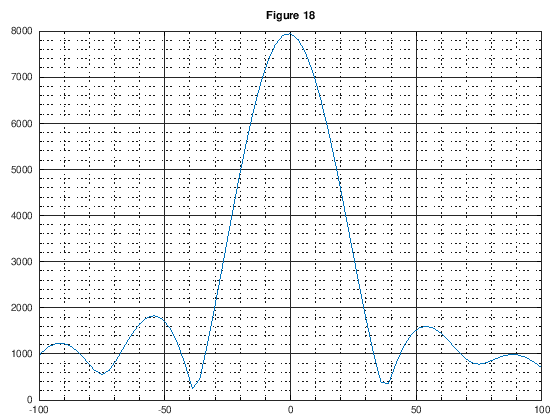

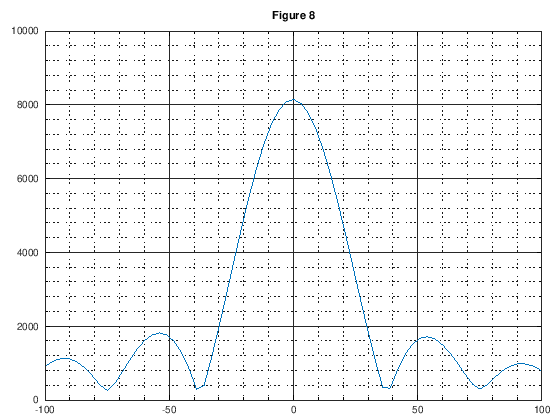

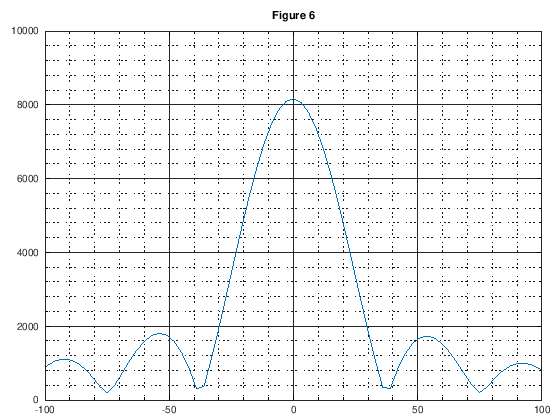

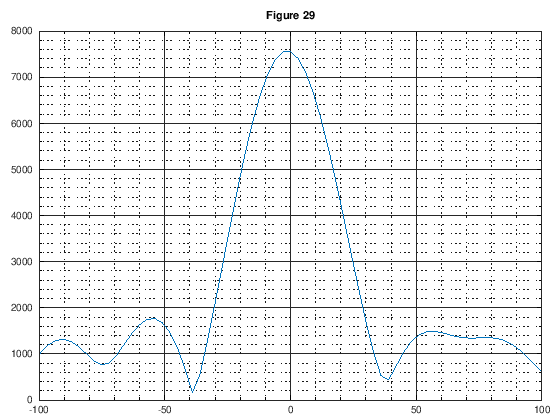

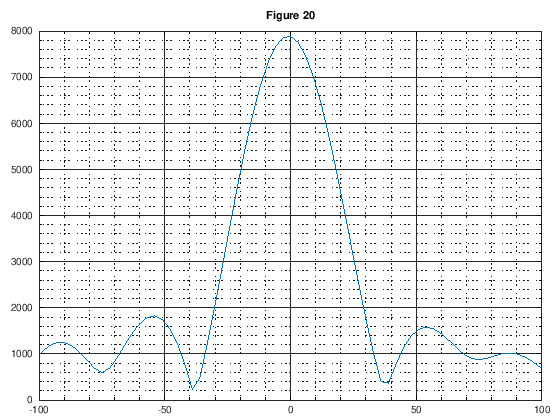

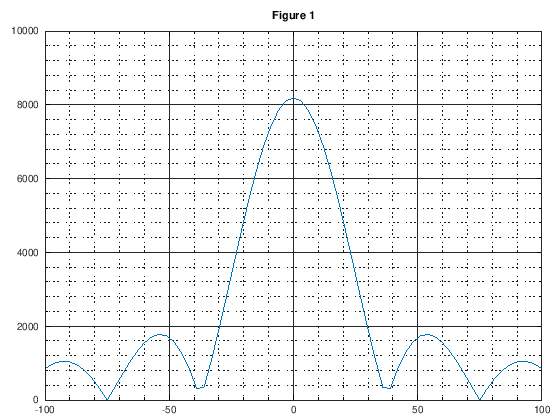

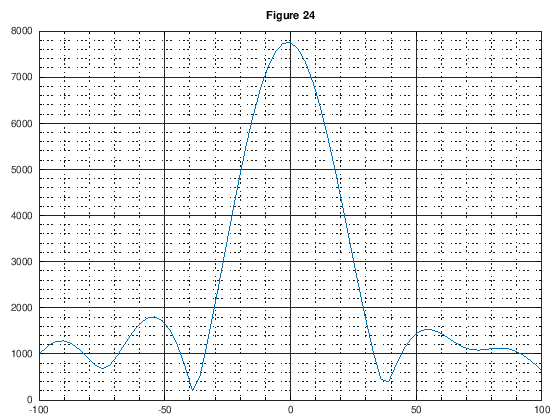

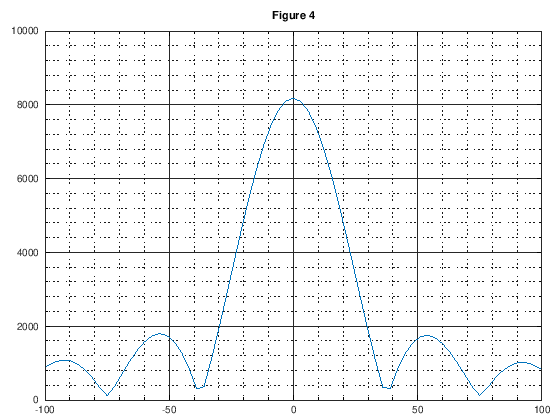

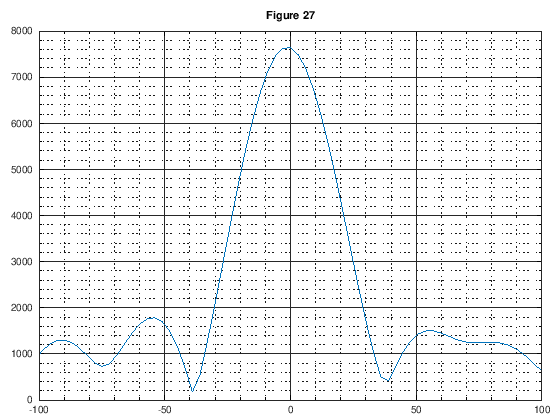

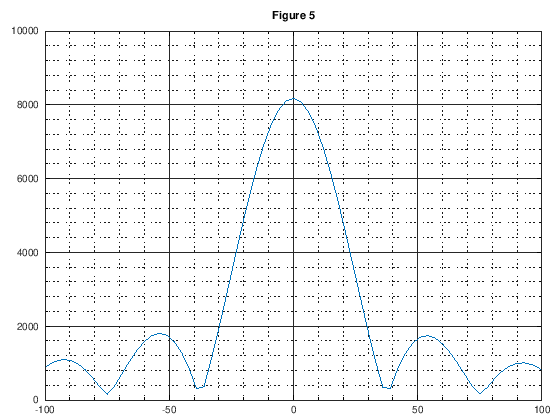

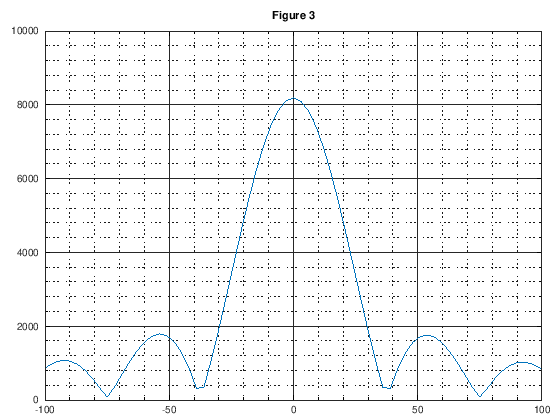

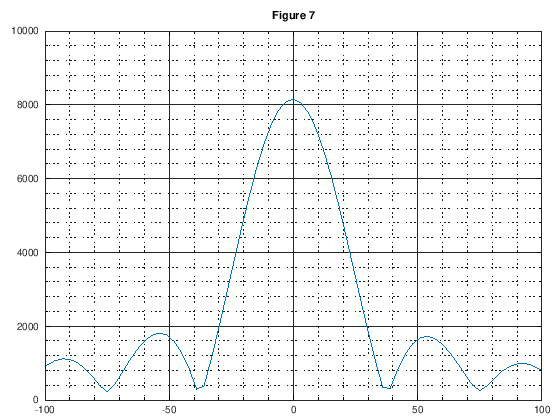

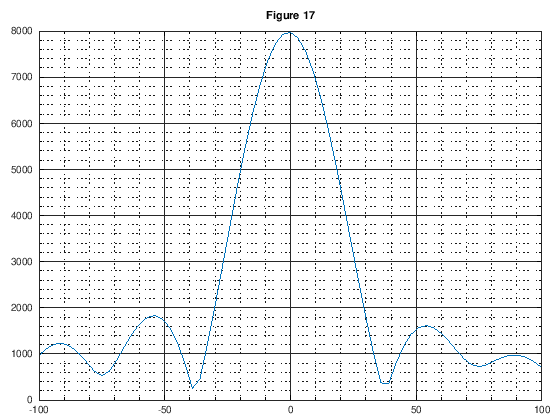

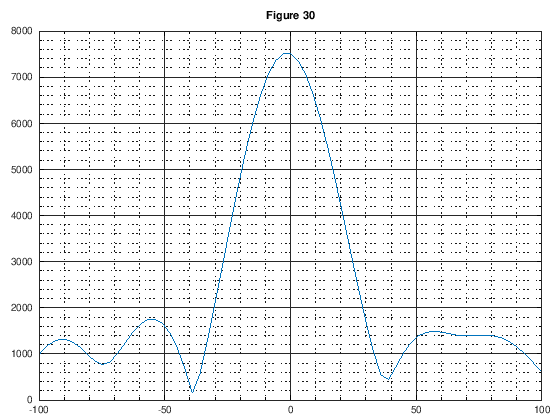

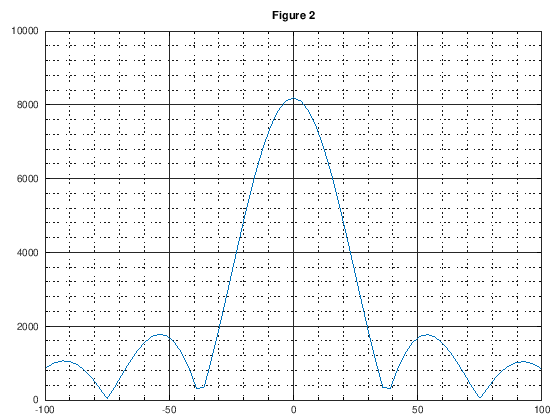

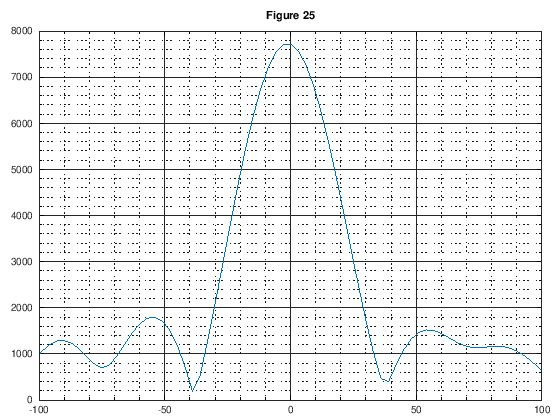

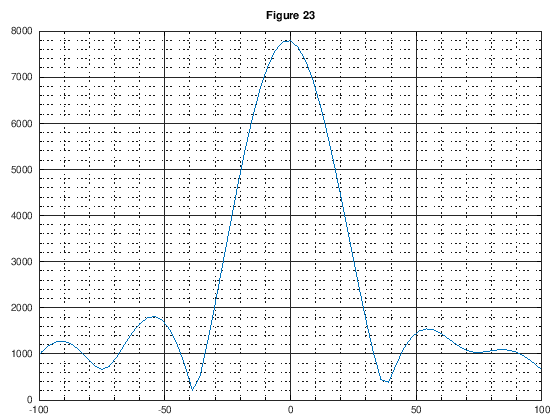

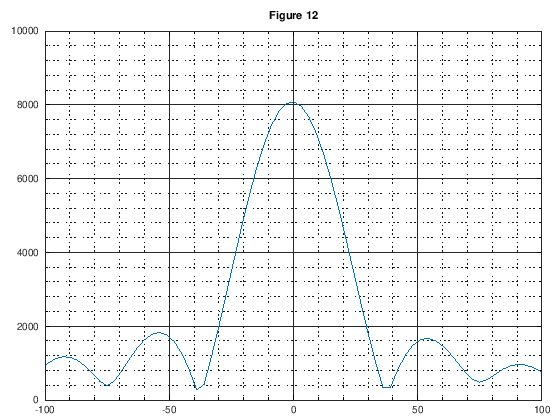

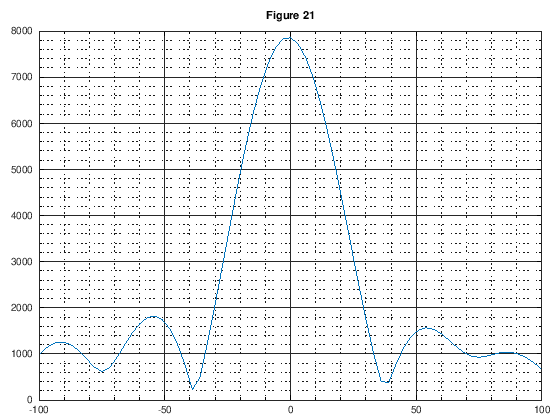

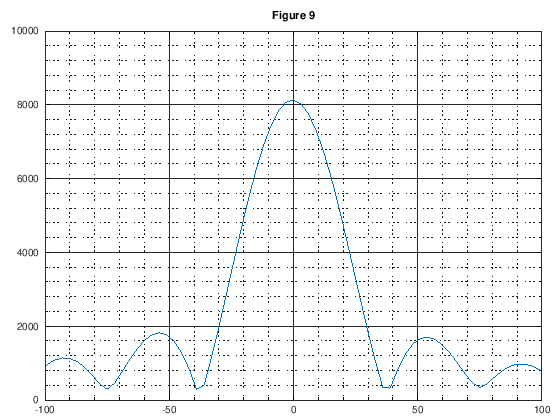

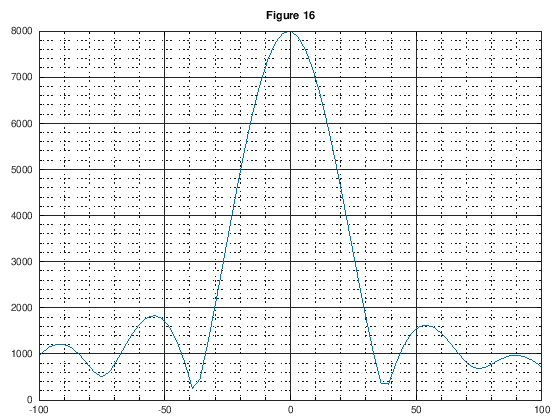

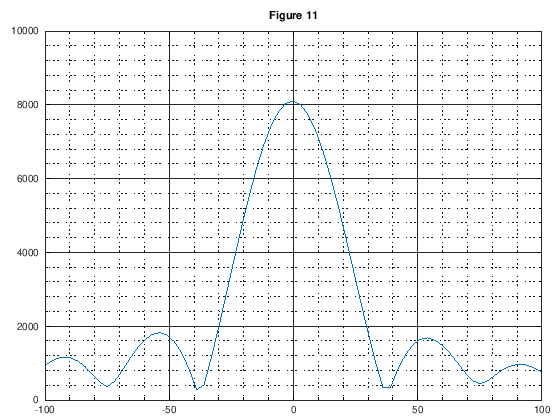

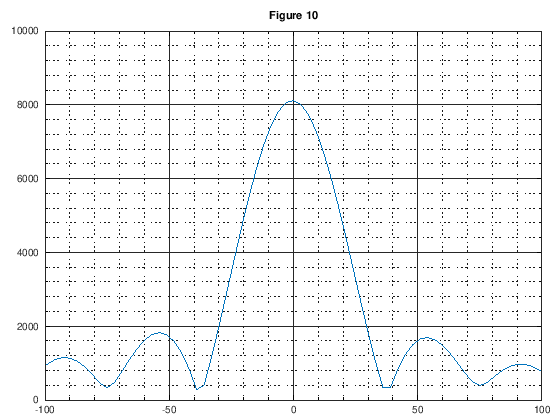

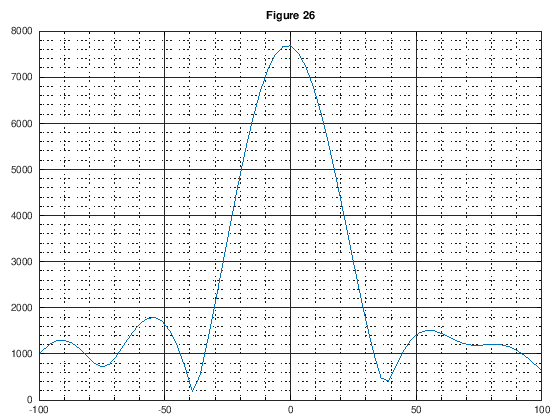

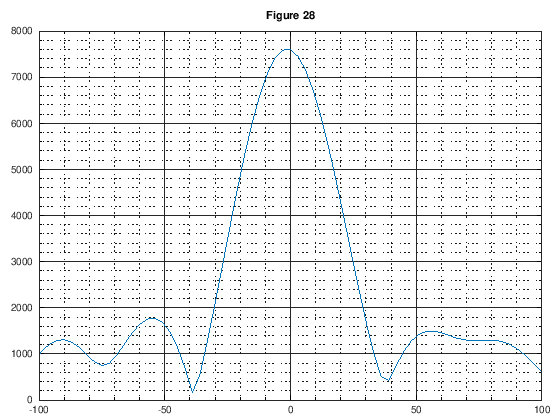

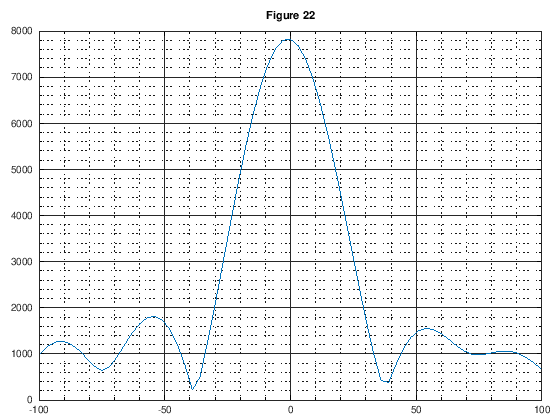

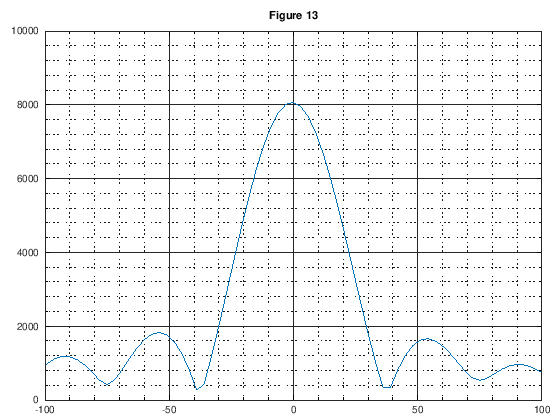

In [75]:
RefSigCV = vertcat(zeros(pulseSamples,1), RefSigCoreCV, zeros(pulseSamples,1));
RefSigConjCV = conj(RefSigCV);
MagCV = [];
i = 1;
# for idx = -pulseSamples:1:pulseSamples
for idx = 0:1:29
  RefSigLoopCV = vertcat(zeros(pulseSamples+idx,1), RefSigCoreCV, zeros(pulseSamples-idx,1));
  RefSigLoopFreqCV = fftshift(fft(RefSigLoopCV .* RefSigConjCV, rows(RefSigLoopCV)*10+1));
  # size(RefSigLoopFreqCV)
  # size(Z)
  
  figure(i);
  newplot()
  plot(linspace(-sampleRate/2, sampleRate/2, rows(RefSigLoopFreqCV)), abs(RefSigLoopFreqCV))
  title(sprintf("Figure %d", i++))
  grid on
  grid minor
  axis([-100 100], "tic")
  drawnow()
  absRefSigLoopFreqCV = abs(RefSigLoopFreqCV);
  MagCV = [MagCV; RefSigLoopFreqCV(find(absRefSigLoopFreqCV == max(absRefSigLoopFreqCV)))];
endfor
size(MagCV)

ans =

   10241       1



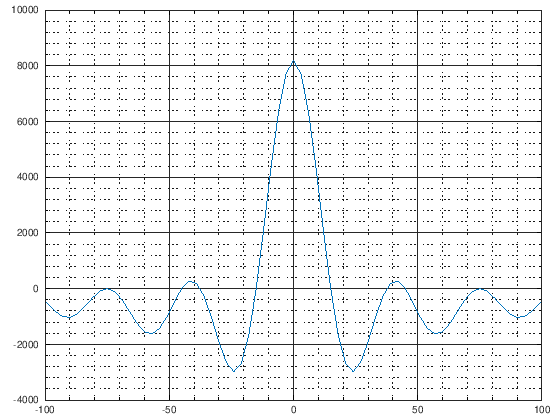

In [63]:
RefSigLoopCV = vertcat(zeros(pulseSamples+0,1), RefSigCoreCV, zeros(pulseSamples-0,1));
size(RefSigLoopCV)
RefSigLoopFreqCV = fftshift(fft(RefSigLoopCV .* RefSigConjCV, rows(RefSigLoopCV)*10+1));
plot(linspace(-sampleRate/2, sampleRate/2, rows(RefSigLoopFreqCV)), RefSigLoopFreqCV)
grid on
grid minor
axis([-100 100], "tic")

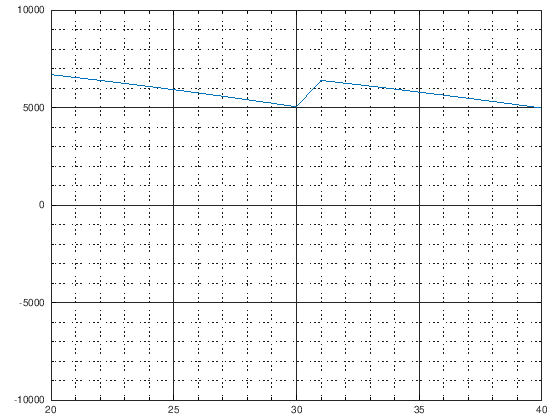

In [68]:
plot(-pulseSamples:1:pulseSamples, MagCV)
grid on
grid minor
axis([20 40], "tic")

## Does Frequency...

In [ ]:
deltaFreq = 0;
RefSigOffsetCV = [ 0 ];
for idx = 1:1:costasN
  SubPulseCV = i * exp(i*2*pi*(deltaFreq + costasFreq(costasFreqIdx(idx)))*TimeCV);
  # Add all but the first sample
  RefSigOffsetCV = vertcat(RefSigOffsetCV, SubPulseCV(2:end));
endfor


RefSigCV = vertcat(zeros(pulseSamples,1), RefSigCoreCV, zeros(pulseSamples,1));
RefSigFreqCV = fft(RefSigCV, rows(RefSigCV)*10);
size(RefSigFreqCV)
RefSigFreqKernelCV = conj(rot90(RefSigFreqCV,2));
MagCV = [];
for idx = -pulseSamples:1:pulseSamples
  RefSigLoopCV = vertcat(zeros(pulseSamples+idx,1), RefSigCoreCV, zeros(pulseSamples-idx,1));
  RefSigLoopFreqCV = fft(RefSigLoopCV, rows(RefSigLoopCV)*10);
  Z = conv2(RefSigLoopFreqCV, RefSigFreqKernelCV, 'valid');
  # size(Z)
  MagCV = [MagCV; Z];
endfor